<a href="https://colab.research.google.com/github/Curiousss/EVA/blob/master/Phase2/Session5/EVAP2S5_PyTorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import Libraries

In [0]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

## Data Transformations

We first start with defining our data transformations. We need to think what our data is and how can we augment it to correct represent images which it might not see otherwise. 


In [0]:
# Train Phase transformations
train_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.RandomRotation((-10, 10), fill=(0,)),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,)) # The mean and std have to be sequences (e.g., tuples), therefore you should add a comma after the values. 
                                       # Note the difference between (0.1307) and (0.1307,)
                                       ])

# Test Phase transformations
test_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,))
                                       ])


# Dataset and Creating Train/Test Split

In [3]:
train = datasets.MNIST('./data', train=True, download=True, transform=train_transforms)
test = datasets.MNIST('./data', train=False, download=True, transform=test_transforms)


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw
Processing...
Done!


# Dataloader Arguments & Test/Train Dataloaders


In [4]:
SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=128, num_workers=0, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

CUDA Available? True


# Data Statistics

It is important to know your data very well. Let's check some of the statistics around our data and how it actually looks like

torch.Size([128, 1, 28, 28])
torch.Size([128])


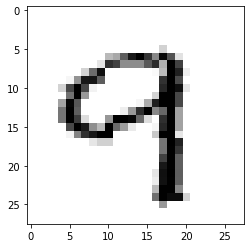

In [5]:
# We'd need to convert it into Numpy! Remember above we have converted it into tensors already
'''
train_data = train.train_data
train_data = train.transform(train_data.numpy())

print('[Train]')
print(' - Numpy Shape:', train.train_data.cpu().numpy().shape)
print(' - Tensor Shape:', train.train_data.size())
print(' - min:', torch.min(train_data))
print(' - max:', torch.max(train_data))
print(' - mean:', torch.mean(train_data))
print(' - std:', torch.std(train_data))
print(' - var:', torch.var(train_data))
'''
dataiter = iter(train_loader)
images, labels = dataiter.next()

print(images.shape)
print(labels.shape)

# Let's visualize some of the images
%matplotlib inline
import matplotlib.pyplot as plt

plt.imshow(images[0].numpy().squeeze(), cmap='gray_r')


## MORE

It is important that we view as many images as possible. This is required to get some idea on image augmentation later on

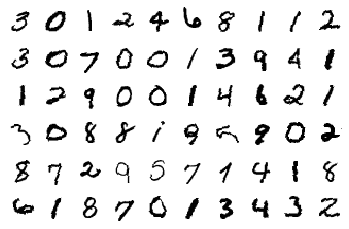

In [6]:
figure = plt.figure()
num_of_images = 60
for index in range(1, num_of_images + 1):
    plt.subplot(6, 10, index)
    plt.axis('off')
    plt.imshow(images[index].numpy().squeeze(), cmap='gray_r')

# The model
Let's start with the model we first saw

In [0]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # Input Block
        self.convblock1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=32, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Dropout(0.1)
        ) # output_size = 26

        # CONVOLUTION BLOCK 1
        self.convblock2 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Dropout(0.1)
        ) # output_size = 24
        self.convblock3 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Dropout(0.1)
        ) # output_size = 22

        # TRANSITION BLOCK 1
        self.pool1 = nn.MaxPool2d(2, 2) # output_size = 11
        self.convblock4 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=32, kernel_size=(1, 1), padding=0, bias=False),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Dropout(0.1)
        ) # output_size = 11

        # CONVOLUTION BLOCK 2
        self.convblock5 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Dropout(0.1)
        ) # output_size = 9
        self.convblock6 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Dropout(0.1)
        ) # output_size = 7

        # OUTPUT BLOCK
        self.convblock7 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
            nn.BatchNorm2d(10),
            nn.ReLU(),
            nn.Dropout(0.1)
        ) # output_size = 7
        self.convblock8 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=10, kernel_size=(7, 7), padding=0, bias=False),
            # nn.ReLU() NEVER!
        ) # output_size = 1

    def forward(self, x):
        x = self.convblock1(x)
        x = self.convblock2(x)
        x = self.convblock3(x)
        x = self.pool1(x)
        x = self.convblock4(x)
        x = self.convblock5(x)
        x = self.convblock6(x)
        x = self.convblock7(x)
        x = self.convblock8(x)
        x = x.view(-1, 10)
        return F.log_softmax(x, dim=-1)

# Model Params
Can't emphasize on how important viewing Model Summary is. 
Unfortunately, there is no in-built model visualizer, so we have to take external help

In [9]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = Net().to(device)
summary(model, input_size=(1, 28, 28))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 26, 26]             288
       BatchNorm2d-2           [-1, 32, 26, 26]              64
              ReLU-3           [-1, 32, 26, 26]               0
           Dropout-4           [-1, 32, 26, 26]               0
            Conv2d-5           [-1, 64, 24, 24]          18,432
       BatchNorm2d-6           [-1, 64, 24, 24]             128
              ReLU-7           [-1, 64, 24, 24]               0
           Dropout-8           [-1, 64, 24, 24]               0
            Conv2d-9          [-1, 128, 22, 22]          73,728
      BatchNorm2d-10          [-1, 128, 22, 22]             256
             ReLU-11          [-1, 128, 22, 22]               0
          Dropout-12          [-1, 128, 22, 22]               0
        MaxPool2d-13          [-1, 128, 11, 11]               0
           Conv2d-14           [-1

# Training and Testing

Looking at logs can be boring, so we'll introduce **tqdm** progressbar to get cooler logs. 

Let's write train and test functions

In [0]:
from tqdm import tqdm

train_losses = []
test_losses = []
train_acc = []
test_acc = []

def train(model, device, train_loader, optimizer, epoch):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes. 
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)
    train_losses.append(loss)

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm
    
    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    test_acc.append(100. * correct / len(test_loader.dataset))

# Let's Train and test our model

In [11]:
model =  Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
EPOCHS = 20
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model, device, train_loader, optimizer, epoch)
    test(model, device, test_loader)

Loss=2.272209405899048 Batch_id=2 Accuracy=14.32:   0%|          | 2/469 [00:00<00:29, 15.88it/s] 

EPOCH: 0


Loss=0.0671660527586937 Batch_id=468 Accuracy=93.76: 100%|██████████| 469/469 [00:25<00:00, 18.74it/s]
Loss=0.09119165688753128 Batch_id=2 Accuracy=97.40:   0%|          | 2/469 [00:00<00:29, 16.08it/s]


Test set: Average loss: 0.0451, Accuracy: 9844/10000 (98.44%)

EPOCH: 1


Loss=0.07506576925516129 Batch_id=468 Accuracy=98.13: 100%|██████████| 469/469 [00:24<00:00, 18.83it/s]
Loss=0.02709820866584778 Batch_id=2 Accuracy=98.96:   0%|          | 2/469 [00:00<00:24, 19.43it/s]


Test set: Average loss: 0.0309, Accuracy: 9902/10000 (99.02%)

EPOCH: 2


Loss=0.0815679058432579 Batch_id=468 Accuracy=98.54: 100%|██████████| 469/469 [00:25<00:00, 19.18it/s]
Loss=0.05825112387537956 Batch_id=2 Accuracy=97.66:   0%|          | 2/469 [00:00<00:24, 19.01it/s] 


Test set: Average loss: 0.0255, Accuracy: 9919/10000 (99.19%)

EPOCH: 3


Loss=0.1537899523973465 Batch_id=468 Accuracy=98.80: 100%|██████████| 469/469 [00:25<00:00, 18.55it/s]
Loss=0.026601653546094894 Batch_id=2 Accuracy=99.22:   0%|          | 2/469 [00:00<00:26, 17.39it/s]


Test set: Average loss: 0.0207, Accuracy: 9934/10000 (99.34%)

EPOCH: 4


Loss=0.03815367817878723 Batch_id=468 Accuracy=98.92: 100%|██████████| 469/469 [00:25<00:00, 18.68it/s]
Loss=0.04962431639432907 Batch_id=2 Accuracy=98.70:   0%|          | 2/469 [00:00<00:24, 19.13it/s]


Test set: Average loss: 0.0197, Accuracy: 9930/10000 (99.30%)

EPOCH: 5


Loss=0.021756693720817566 Batch_id=468 Accuracy=99.00: 100%|██████████| 469/469 [00:24<00:00, 19.53it/s]
Loss=0.042432770133018494 Batch_id=3 Accuracy=99.80:   1%|          | 3/469 [00:00<00:22, 20.59it/s]  


Test set: Average loss: 0.0222, Accuracy: 9924/10000 (99.24%)

EPOCH: 6


Loss=0.04540656507015228 Batch_id=468 Accuracy=99.02: 100%|██████████| 469/469 [00:24<00:00, 19.06it/s]
Loss=0.017597287893295288 Batch_id=2 Accuracy=99.48:   0%|          | 2/469 [00:00<00:25, 18.42it/s]


Test set: Average loss: 0.0195, Accuracy: 9934/10000 (99.34%)

EPOCH: 7


Loss=0.006803631782531738 Batch_id=468 Accuracy=99.14: 100%|██████████| 469/469 [00:25<00:00, 18.61it/s]
Loss=0.04413817450404167 Batch_id=2 Accuracy=99.22:   1%|          | 3/469 [00:00<00:23, 19.50it/s]


Test set: Average loss: 0.0185, Accuracy: 9934/10000 (99.34%)

EPOCH: 8


Loss=0.05412374064326286 Batch_id=468 Accuracy=99.13: 100%|██████████| 469/469 [00:24<00:00, 18.84it/s]
Loss=0.02669890969991684 Batch_id=3 Accuracy=99.22:   1%|          | 3/469 [00:00<00:23, 20.08it/s] 


Test set: Average loss: 0.0185, Accuracy: 9934/10000 (99.34%)

EPOCH: 9


Loss=0.06531070917844772 Batch_id=468 Accuracy=99.19: 100%|██████████| 469/469 [00:24<00:00, 18.85it/s]
Loss=0.006265934556722641 Batch_id=2 Accuracy=99.22:   0%|          | 2/469 [00:00<00:23, 19.70it/s]


Test set: Average loss: 0.0167, Accuracy: 9942/10000 (99.42%)

EPOCH: 10


Loss=0.024177083745598793 Batch_id=468 Accuracy=99.27: 100%|██████████| 469/469 [00:24<00:00, 19.14it/s]
Loss=0.007002484053373337 Batch_id=2 Accuracy=99.22:   0%|          | 2/469 [00:00<00:26, 17.89it/s]


Test set: Average loss: 0.0166, Accuracy: 9945/10000 (99.45%)

EPOCH: 11


Loss=0.012508084066212177 Batch_id=468 Accuracy=99.27: 100%|██████████| 469/469 [00:25<00:00, 18.68it/s]
Loss=0.049648672342300415 Batch_id=2 Accuracy=98.18:   0%|          | 2/469 [00:00<00:25, 18.53it/s]


Test set: Average loss: 0.0188, Accuracy: 9934/10000 (99.34%)

EPOCH: 12


Loss=0.009876529686152935 Batch_id=468 Accuracy=99.28: 100%|██████████| 469/469 [00:24<00:00, 18.88it/s]
Loss=0.024247946217656136 Batch_id=2 Accuracy=99.48:   0%|          | 2/469 [00:00<00:25, 18.64it/s]


Test set: Average loss: 0.0160, Accuracy: 9944/10000 (99.44%)

EPOCH: 13


Loss=0.00259389984421432 Batch_id=468 Accuracy=99.35: 100%|██████████| 469/469 [00:24<00:00, 18.87it/s]
Loss=0.008481413125991821 Batch_id=2 Accuracy=99.48:   0%|          | 2/469 [00:00<00:25, 18.22it/s]


Test set: Average loss: 0.0176, Accuracy: 9939/10000 (99.39%)

EPOCH: 14


Loss=0.009816507808864117 Batch_id=468 Accuracy=99.31: 100%|██████████| 469/469 [00:24<00:00, 18.81it/s]
Loss=0.03321020305156708 Batch_id=2 Accuracy=99.22:   0%|          | 2/469 [00:00<00:23, 19.80it/s] 


Test set: Average loss: 0.0156, Accuracy: 9946/10000 (99.46%)

EPOCH: 15


Loss=0.0032763928174972534 Batch_id=468 Accuracy=99.33: 100%|██████████| 469/469 [00:24<00:00, 18.96it/s]
Loss=0.00784732773900032 Batch_id=2 Accuracy=99.74:   0%|          | 2/469 [00:00<00:26, 17.86it/s] 


Test set: Average loss: 0.0157, Accuracy: 9944/10000 (99.44%)

EPOCH: 16


Loss=0.007917706854641438 Batch_id=468 Accuracy=99.37: 100%|██████████| 469/469 [00:24<00:00, 19.17it/s]
Loss=0.013657532632350922 Batch_id=2 Accuracy=99.22:   0%|          | 2/469 [00:00<00:23, 19.47it/s]


Test set: Average loss: 0.0164, Accuracy: 9949/10000 (99.49%)

EPOCH: 17


Loss=0.014008601196110249 Batch_id=468 Accuracy=99.41: 100%|██████████| 469/469 [00:24<00:00, 18.87it/s]
Loss=0.025414451956748962 Batch_id=2 Accuracy=97.92:   0%|          | 2/469 [00:00<00:25, 18.32it/s]


Test set: Average loss: 0.0153, Accuracy: 9942/10000 (99.42%)

EPOCH: 18


Loss=0.00539851188659668 Batch_id=468 Accuracy=99.41: 100%|██████████| 469/469 [00:24<00:00, 18.77it/s]
Loss=0.0002523288130760193 Batch_id=2 Accuracy=99.48:   0%|          | 2/469 [00:00<00:25, 18.06it/s]


Test set: Average loss: 0.0158, Accuracy: 9943/10000 (99.43%)

EPOCH: 19


Loss=0.005580907221883535 Batch_id=468 Accuracy=99.43: 100%|██████████| 469/469 [00:24<00:00, 18.79it/s]



Test set: Average loss: 0.0146, Accuracy: 9954/10000 (99.54%)



Text(0.5, 1.0, 'Test Accuracy')

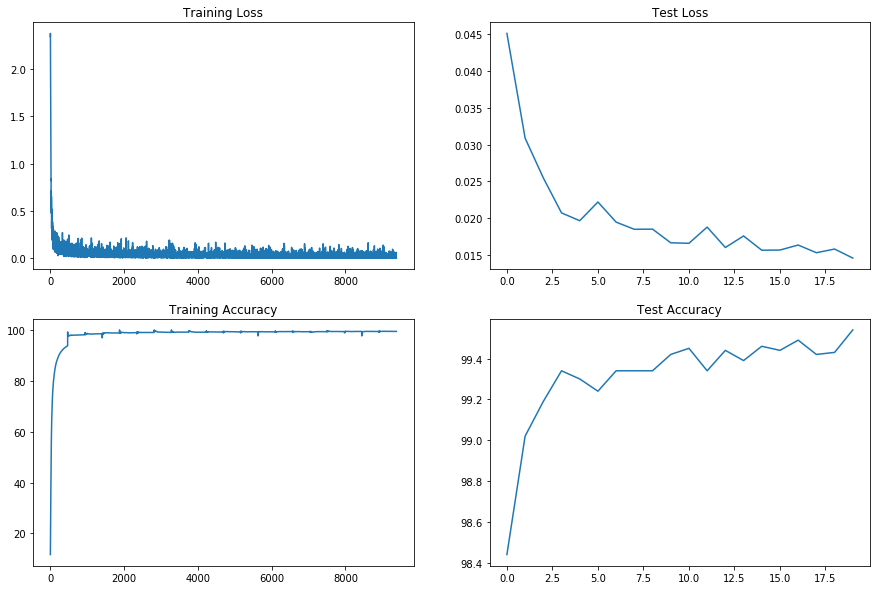

In [12]:
fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(train_losses)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc)
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")